finds all solutions to n by n sudoku, where n is an integer power of 2

In [31]:
from enum import Enum

import math

from qiskit import QuantumCircuit, Aer, execute, transpile, IBMQ, assemble
from qiskit.providers.aer import AerSimulator
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [32]:
def mcz(qc, qubits):
  qc.h(qubits[-1])
  qc.mct(qubits[ : -1], qubits[-1])
  qc.h(qubits[-1])

In [33]:
def xor_all_bits(qc, a, b, target, num_len):
   for i in range(num_len):
    qc.cx(a + i, target + i)
    qc.cx(b + i, target + i)

def xor(qc, a, b, target, final_target, num_len):
  xor_all_bits(qc, a, b, target, num_len)

  # make final target 1 if atleast one bit is different
  for i in range(num_len):
    qc.cx(target + i, final_target)
  for i in range(num_len - 1):
    for j in range(i + 1, num_len):
      qc.ccx(target + i, target + j, final_target)
  if num_len % 2 == 0 and (((num_len - 1) * num_len) / 2) % 2 == 0 :
    qc.mct(list(range(target, num_len)), final_target)

  xor_all_bits(qc, a, b, target, num_len) # reset aux qubits

def qubit_index(row, col, n):
  return (row * n) + col

def xor_all(qc, n, num_elems, num_len, final_target):
  target = num_elems * num_len
  for i in range(n):
    for j in range(n - 1):
      for k in range(j + 1, n):
        xor(qc, qubit_index(i, j, n), qubit_index(i, k, n), target, final_target, num_len)
        final_target += 1
        xor(qc, qubit_index(j, i, n), qubit_index(k, i, n), target, final_target, num_len)
        final_target += 1

def mct(qc, final_target):
  qc.mct(list(range(final_target, qc.num_qubits - 1)), qc.num_qubits - 1)

def oracle(qc, n, num_elems, num_len):
  final_target = (num_elems * num_len) + num_len

  xor_all(qc, n, num_elems, num_len, final_target)
  mct(qc, final_target)

  # exactly one num in each row has all 1s in binary, 
  # so correct solutions will get negative amplitude only once
  for i in range(n):
    index = qubit_index(0, i, n)
    last_bit = index + (num_len - 1)
    mcz(qc, list(range(index, last_bit)) + [qc.num_qubits - 1, last_bit])

  # reset aux qubits
  mct(qc, final_target)
  xor_all(qc, n, num_elems, num_len, final_target)

In [34]:
def diffuser(qc, num_qubits):

  for i in range(num_qubits):
    qc.h(i)
    qc.x(i)

  mcz(qc, list(range(num_qubits)))

  for i in range(num_qubits):
    qc.x(i)
    qc.h(i)

In [35]:
class Backend(Enum):
  QASM = "qasm_simulator"
  MATRIX = "matrix_product_state"
  EXTENDED = "extended_stabilizer"
  STABILIZER = "stabilizer"
  QUANTUM_COMPUTER = None

OPTIMIZATION = 3

def sim(qc, backend):
  counts = None
  if backend == Backend.QASM:
    counts = execute(qc, Aer.get_backend(backend.value), shots = SHOTS).result().get_counts()
  elif backend == Backend.QUANTUM_COMPUTER:
    IBMQ.save_account("bbeb8005b8060940e0f37d88fd1f8c35ee3883c7c558e8c217bbd2ae97c348031548c16f5468063e5359d95038c69b3fbe85230b2fcc9df7a3c89d2a924738e2")
    IBMQ.load_account()
    provider = IBMQ.get_provider("ibm-q")
    device = least_busy(
        provider.backends(filters = lambda x: x.configuration().n_qubits >= qc.num_qubits and 
            not x.configuration().simulator and x.status().operational == True))
    transpiled = transpile(qc, device, optimization_level = OPTIMIZATION)
    qobj = assemble(transpiled)
    job = device.run(qobj)
    job_monitor(job, interval = 2)
    counts = job.result().get_counts(qc)
  else:
    sim = AerSimulator(method = backend.value)
    counts = sim.run(qc, shots = SHOTS).result().get_counts()
  return counts

In [36]:
SHOTS = 1024

def num_vals(n):
  num_elems = n * n
  num_len = int(math.log2(n))
  return (num_elems, num_len, num_elems * num_len)

def qc_num_qubits(n):
  num_elems, num_len, num_qubits = num_vals(n)
  return num_qubits + num_len + ((math.comb(n, 2) * n) * 2) + 1

def sudoku(n, backend = Backend.QASM):
  pow = math.log2(n)
  if n <= 1 or pow != int(pow):
    print("n must be a power of 2 that is an integer and greater than 0")
    return

  # num of elems in n by n grid, len in bits of each number, total num qubits in grid
  num_elems, num_len, num_qubits = num_vals(n)
  qc = QuantumCircuit(qc_num_qubits(n), num_qubits)

  for i in range(num_qubits):
    qc.h(i)
  
  for i in range(n):
    oracle(qc, n, num_elems, num_len)
    diffuser(qc, num_qubits)

  qubits = list(range(num_qubits))
  qc.measure(qubits, qubits[ : : -1])

  return sim(qc, backend)

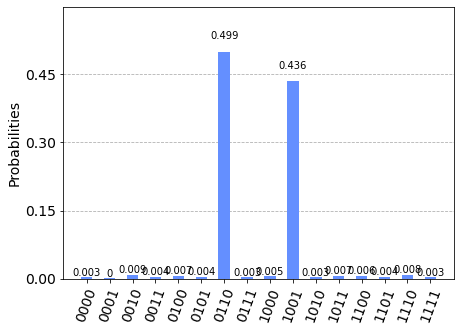

In [37]:
counts = sudoku(2, Backend.QASM)
plot_histogram(counts)